# Entrenamiento para detectar caídas
## Importaciones

In [26]:
import cv2
import numpy as np
import os
from pose_estimation import PoseEstimation
import pandas

## Constantes

In [27]:
videos_path = "videos/"
expected_pixels = 257
frame_rate = 5
body_parts = ["nose", "leftEye", "rightEye", "leftEar", "rightEar", "leftShoulder", "rightShoulder",
                  "leftElbow", "rightElbow", "leftWrist", "rightWrist", "leftHip", "rightHip", "leftKnee",
                  "rightKnee", "leftAnkle", "rightAnkle"]

## Preprocesamiento
#### En primer lugar abrimos el directorio donde se encuentran los vídeos, es importante que en esta carpeta (videos) solo hayan carpetas que contengan vídeos de 3 segundos
Se extraen las diferentes partes del cuerpo del modelo Posenet y se normalizan los datos.

La entrada del algoritmo de aprendizaje será así:

- Frame0_nose_X,Frame0_nose_Y,…,Frame[i]_[keypoint_j]_X, Frame[i]_[keypoint_j]_Y,…,[resultado].
Siéndo [i] el número de frame, [keypoint_j] la parte del cuerpo y [resultado] el estado al que corresponden los datos.


Donde cada línea es un vídeo.

In [28]:
# Cogemos el nombre de las clases (los estados) de las carpetas que contienen los vídeos
class_names = [x[0].split("/")[1] for x in os.walk(videos_path)][1:]
data = None
pe = PoseEstimation()
for class_name in class_names:
    videos = [x[2] for x in os.walk("{}{}".format(videos_path, class_name))][0]
    for file in videos:
        video_data = None
        video = cv2.VideoCapture("{}{}/{}".format(videos_path, class_name, file))
        video_rate = int(np.round(video.get(cv2.CAP_PROP_FPS) / frame_rate))
        while video.isOpened():
            frame_number = video.get(1) # current frame number
            ret, frame = video.read()
            if not ret: break
            if frame_number % video_rate == 0:
                frame = pe.make_square(frame, pe.expected_pixels)
                pose = pe.get_pose_estimation(frame)

                # Normalizing position
                #average_x = np.mean(pose[:, 0])
                #average_y = np.mean(pose[:, 1])
                #pose[:, 0] = pose[:, 0] - average_x
                #pose[:, 1] = pose[:, 1] - average_y

                # Normalizing scale
                max_val = np.max(np.abs(pose))
                pose[:] = pose[:] / max_val

                pose = pose.reshape(-1)
                if video_data is None:
                    video_data = pose
                else:
                    video_data = np.hstack((video_data, pose))
        video.release()
        video_data = np.append(video_data, class_name)
        if data is None:
            data = video_data
        else:
            data = np.vstack((data, video_data))

Ponemos nombre a las cabeceras y guardamos los resultados en un archivo .csv

In [29]:
header = None

body_parts_len = len(body_parts)
data_len = len(data[0]) -1
elements_per_part = 2 #  porque cada parte del cuerpo tiene X e Y
frame = -1
for i in range(0, data_len, elements_per_part):
    if i % body_parts_len == 0:
        frame += 1
    body_part = body_parts[int(i/elements_per_part)%body_parts_len]
    title = "Frame_{}_{}".format(frame, body_part)
    if header is None:
        header = "{}_X".format(title)
    else:
        header = np.hstack((header, "{}_X".format(title)))
    header = np.hstack((header, "{}_Y".format(title)))
    #header = np.hstack((header, "{}_Reliable".format(title)))
header = np.hstack((header, "class"))

pandas.DataFrame(data).to_csv("data/data.csv", header=header, index=False)

## Entrenamiento
Creamos el set de validación

In [520]:
import pandas
from sklearn.model_selection import train_test_split

data = pandas.read_csv("data/data.csv")
y = data[:]['class']
data = data.iloc[: , :-1]
x_train, x_test, y_train, y_test = train_test_split(data, y, random_state=42, test_size=0.2)

Método para mostrar los resultados para cada algoritmo

In [504]:
from sklearn.metrics import classification_report, plot_confusion_matrix
def mostrar_resultados(modelo, algoritmo):
    y_pred = modelo.predict(x_test)
    print("{} report \n".format(algoritmo), classification_report(y_test, y_pred))
    print(plot_confusion_matrix(modelo, x_test, y_test, display_labels=class_names))

    # Falsos positivos y falsos negativos de caídas
    fp = 0
    fn = 0
    np_y_test = y_test.to_numpy()
    for j in range(len(y_pred)):
        if y_pred[j] == "Fall" != np_y_test[j]:
            fp = fp + 1
        elif np_y_test[j] == "Fall" != y_pred[j]:
            fn = fn + 1
    print("FP = {} | FN = {}".format(fp, fn))


### Aplicamos un algoritmo de aprendizaje
### RandomForestClassifier

Random Forest Classifier report 
               precision    recall  f1-score   support

        Fall       0.89      0.89      0.89         9
     Nothing       1.00      0.90      0.95        10
     Recover       0.86      1.00      0.92         6

    accuracy                           0.92        25
   macro avg       0.92      0.93      0.92        25
weighted avg       0.93      0.92      0.92        25

FP = 1 | FN = 1


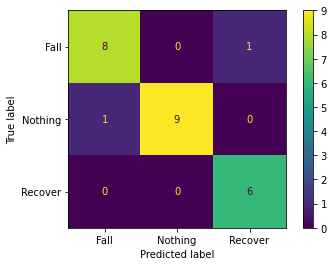

In [507]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(criterion="gini", min_samples_split=2, max_depth=None, n_estimators=50, random_state=16)
random_forest_model.fit(x_train, y_train)
mostrar_resultados(random_forest_model, "Random Forest Classifier")

### Neural Networks

Neural Network Classifier report 
               precision    recall  f1-score   support

        Fall       0.73      0.89      0.80         9
     Nothing       1.00      0.80      0.89        10
     Recover       0.67      0.67      0.67         6

    accuracy                           0.80        25
   macro avg       0.80      0.79      0.79        25
weighted avg       0.82      0.80      0.80        25



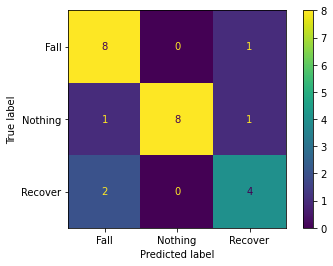

In [404]:
from sklearn.neural_network import MLPClassifier
neural_network_model = MLPClassifier(solver="lbfgs", activation="identity", hidden_layer_sizes=20)
neural_network_model.fit(x_train, y_train)
mostrar_resultados(neural_network_model, "Neural Network Classifier")


### Gradient Boosting Tree

Gradient Boosting Classifier report 
               precision    recall  f1-score   support

        Fall       0.78      0.78      0.78         9
     Nothing       0.89      0.80      0.84        10
     Recover       0.86      1.00      0.92         6

    accuracy                           0.84        25
   macro avg       0.84      0.86      0.85        25
weighted avg       0.84      0.84      0.84        25

FP = 2 | FN = 2


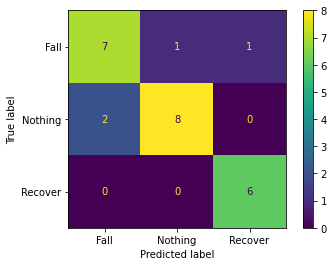

In [506]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_boosting_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, random_state=20)
gradient_boosting_model.fit(x_train, y_train)
mostrar_resultados(gradient_boosting_model, "Gradient Boosting Classifier")


## Buscamos qué algoritmo da menos falsos negativos

In [518]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

random_forest_fp = 0
random_forest_fn = 0
gradient_boosting_fp = 0
gradient_boosting_fn = 0

def get_fp_fn(predecido, real, estado, fp, fn):
    for i in range(len(predecido)):
        if predecido[i] == estado != real[i]:
            fp += 1
        elif real[i] == estado != predecido[i]:
            fn += 1
    return fp, fn

veces_a_repetir = 100
for i in range(veces_a_repetir):
    rf_model = RandomForestClassifier(n_estimators=50, criterion="gini", min_samples_split=2, max_depth=None)
    gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50)
    rf_model.fit(x_train, y_train)
    gb_model.fit(x_train, y_train)
    rf_y = rf_model.predict(x_test)
    gb_y = gb_model.predict(x_test)

    np_y_test = y_test.to_numpy()
    random_forest_fp, random_forest_fn = get_fp_fn(rf_y, np_y_test, "Fall", random_forest_fp, random_forest_fn)
    gradient_boosting_fp, gradient_boosting_fn = get_fp_fn(gb_y, np_y_test, "Fall",gradient_boosting_fp, gradient_boosting_fn)

muestras_totales = len(np_y_test) * veces_a_repetir
print("Random Forest     | FP = {}, {}% | FN = {}, {}%".format(random_forest_fp, random_forest_fp/muestras_totales*100,
                                                             random_forest_fn, random_forest_fn/muestras_totales*100))
print("Gradient Boosting | FP = {}, {}% | FN = {}, {}%".format(gradient_boosting_fp, gradient_boosting_fp/muestras_totales*100,
                                                             gradient_boosting_fn, gradient_boosting_fn/muestras_totales*100))

Random Forest     | FP = 212, 8.48% | FN = 100, 4.0%
Gradient Boosting | FP = 123, 4.92% | FN = 178, 7.12%


## Guardamos el mejor modelo

In [522]:
import pickle

best_random_forest_model = RandomForestClassifier(criterion="gini", min_samples_split=2, max_depth=None, n_estimators=50, random_state=16)
best_random_forest_model.fit(data, y)

pickle.dump(best_random_forest_model, open("model/HSC.sav", 'wb'))
#import pickle
#base_model = pickle.load(open("model/HSC.sav", 'rb'))
